In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import clear_output

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
INPUT_DIM = 784
NR_HIDDEN = 500
LATENT_VAR_UNITS = 20
LATENT_VAR_DEPTH = 10

def build_input(batch_size):
    input_ = tf.placeholder(tf.float32, shape=(batch_size, INPUT_DIM))
    keep_prob = tf.placeholder(tf.float32, shape=())
    tau = tf.placeholder(tf.float32, shape=())
    return input_, keep_prob, tau

def build_encoder(input_, keep_prob, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        h0 = tf.layers.dense(input_, units=NR_HIDDEN, activation=tf.nn.elu)
        h0 = tf.nn.dropout(h0, keep_prob=keep_prob)

        h1 = tf.layers.dense(h0, units=NR_HIDDEN, activation=tf.nn.tanh)
        h1 = tf.nn.dropout(h1, keep_prob=keep_prob)

    return h1

def build_decoder(gumbel_softmax_sample, keep_prob, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
        h2 = tf.layers.dense(gumbel_softmax_sample, units=NR_HIDDEN, activation=tf.nn.tanh)
        h2 = tf.nn.dropout(h2, keep_prob=keep_prob)

        h3 = tf.layers.dense(h2, units=NR_HIDDEN, activation=tf.nn.elu)
        logits = tf.nn.dropout(h3, keep_prob=keep_prob)

        logits = tf.layers.dense(h3, units=INPUT_DIM, activation=None)

        return logits
        
def build_gumbel_vars(shape):
    # randoms like tf.random_uniform are initialized once per 'run' method call.
    #
    # during training, each batch will get a separate call to sess.run([opt], ...)
    # 
    # so we can integrate a tensor computed from 'build_gumbel_vars' into our network,
    # and the gumbels sampled each batch will have different values vs their prev batch
    
    unif_rand = tf.random_uniform(shape, minval=0.0, maxval=1.0)
    gumbel_vars = -tf.log(-tf.log(unif_rand + 1e-8) + 1e-8)
    return gumbel_vars

def build_gumbel_softmax(classprobs, gumbels, tau):
    logits = gumbels + tf.log(classprobs)
    gumbel_softmax = tf.nn.softmax((logits / tau), dim=2)
    return gumbel_softmax

def build_gumbel_softmax_from_classprob_logits(classprob_logits, gumbels, tau):
    logits = gumbels + classprob_logits
    gumbel_softmax = tf.nn.softmax((logits / tau), dim=2)
    return gumbel_softmax

In [5]:
class GumbelSoftmaxVAE:
    def __init__(self, batch_size):
        # input image x (shape=(batch_size,784))
        self.x, self.keep_prob, self.tau = build_input(batch_size)
        
        self.encode_net = build_encoder(self.x, self.keep_prob, reuse=False)
        
        # unnormalized logits for LATENT_VAR_UNITS separate LATENT_VAR_DEPTH-categorical distributions 
        # (shape=(batch_size*N,K))
        self.logits_y = tf.reshape(
            tf.layers.dense(self.encode_net, 
                            units=LATENT_VAR_UNITS*LATENT_VAR_DEPTH, 
                            activation=None), 
            [batch_size,LATENT_VAR_UNITS,LATENT_VAR_DEPTH])
        
        self.q_y = tf.nn.softmax(self.logits_y, dim=2)
        self.log_q_y = tf.log(self.q_y + 1e-8)
        
        gumbels = build_gumbel_vars(self.q_y.shape)
        
        #self.gumbel_softmax_sample = build_gumbel_softmax(self.q_y, gumbels, self.tau)
        #
        # ^^^
        # As far as I can tell, below is actually not logically equivalent w code above. 
        # Seems like this would cause less influence by gumbel randomness when running softmax. 
        #   for some reason, it's what eric jang did. 
        # I haven't quite figured out why.
        #
        self.gumbel_softmax_sample = build_gumbel_softmax_from_classprob_logits(
            self.logits_y, 
            gumbels, 
            self.tau)
        
        # generative model p(x|y), i.e. the decoder (shape=(batch_size,200))
        self.pixel_class_logits = build_decoder(self.gumbel_softmax_sample, self.keep_prob)
        self.output = tf.nn.sigmoid(self.pixel_class_logits)[:,1]
        
        # loss and train ops
        self.kl_tmp = tf.reshape(self.q_y*(self.log_q_y-tf.log(1.0/LATENT_VAR_DEPTH)),
                                 [batch_size,LATENT_VAR_UNITS,LATENT_VAR_DEPTH])
        self.KL = tf.reduce_sum(self.kl_tmp,[1,2])
        self.elbo=tf.reduce_sum(self.x * tf.log(self.output) + (1 - self.x) * tf.log(1 - self.output),1) - self.KL
        
        self.loss=tf.reduce_mean(-self.elbo)
        self.lr=tf.placeholder(tf.float32, shape=())
        self.train_op=tf.train.AdamOptimizer(learning_rate=self.lr).minimize(
            self.loss,
            var_list=tf.trainable_variables())

In [6]:
tf.reset_default_graph()
BATCH_SIZE=100
NUM_ITERS=50000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.5
vae = GumbelSoftmaxVAE(batch_size=BATCH_SIZE)

In [10]:
dat = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1,NUM_ITERS):
        np_x, np_y = mnist.train.next_batch(BATCH_SIZE) 
        feed_dict = {vae.x: np_x,
                     vae.keep_prob: 0.9,
                     vae.tau: np_temp,
                     vae.lr: np_lr
                    }
        
        _, np_loss =sess.run([vae.train_op, vae.loss], feed_dict=feed_dict)
              
        clear_output(wait=True)
        print('Step %d, ELBO: %0.3f' % (i,-np_loss))
        
        if i % 100 == 1:
            dat.append([i, np_temp, np_loss])
        if i % 1000 == 1:
            np_temp=np.maximum(tau0 * np.exp(-ANNEAL_RATE*i), MIN_TEMP)
            np_lr*=0.9
        if i % 2000 == 1:
            saver.save(sess, './checkpoints/vae-gumbelsoftmax-hidden' + \
                       str(NR_HIDDEN) + \
                       '-latent' + \
                       str(LATENT_VAR_UNITS) + \
                       '-classes' + \
                       str(LATENT_VAR_DEPTH))

Step 49999, ELBO: -158.286


In [11]:
def makesquares(images, nr_images_per_side):
    images_to_plot = np.concatenate(
        [np.concatenate([images[j*nr_images_per_side+i].reshape((28,28)) for i in range(0,nr_images_per_side)], 
                        axis=1)
         for j in range(0,nr_images_per_side)], 
        axis=0)
    return images_to_plot

def plotsquares(originals, reconstructs, nr_images_per_side):
    originals_square = makesquares(originals, nr_images_per_side)
    reconstructs_square = makesquares(reconstructs, nr_images_per_side)
    combined = np.concatenate([originals_square, reconstructs_square], axis=1)
    plt.imshow(combined)

INFO:tensorflow:Restoring parameters from ./checkpoints/vae-gumbelsoftmax-hidden500-latent20-classes10


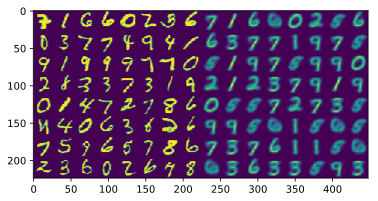

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './checkpoints/vae-gumbelsoftmax-hidden' + \
                       str(NR_HIDDEN) + \
                       '-latent' + \
                       str(LATENT_VAR_UNITS) + \
                       '-classes' + \
                       str(LATENT_VAR_DEPTH))
    
    for i in range(1,NUM_ITERS):
        np_x, np_y = mnist.train.next_batch(BATCH_SIZE) 
        feed_dict = {vae.x: np_x,
                     vae.keep_prob: 1.0,
                     vae.tau: 0.0001,
                     vae.lr: np_lr
                    }
        
        output, np_loss = sess.run([vae.output, vae.loss], feed_dict=feed_dict)
        plotsquares(np_x, output, 8)
        
        break

In [16]:
# it got several wrong O_o
#
# that's probably at least in part caused by us sampling from the gumbel-softmax at test time,
# instead of using the one-hot encoding of the argmax of the encoded class probabilities y

In [ ]:
# but at this point, tau is really low. so it should be like an argmax anyway. not sure.
# will investigate further.